In [1]:
!pip install jinja2 --upgrade
!pip install ipywidgets --upgrade

!pip install earthengine-api geemap pandas numpy requests matplotlib rasterio

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: jinja2 in ./.local/lib/python3.7/site-packages (3.1.4)
Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: ipywidgets in ./.local/lib/python3.7/site-packages (8.1.3)
Defaulting to user installation because normal site-packages is not writeable
  Using cached rasterio-1.2.10-cp37-cp37m-manylinux1_x86_64.whl (19.3 MB)
  Using cached ipywidgets-7.8.2-py2.py3-none-any.whl (124 kB)
  Using cached jupyterlab_widgets-1.1.8-py3-none-any.whl (237 kB)
  Using cached widgetsnbextension-3.6.7-py2.py3-none-any.whl (1.5 MB)
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.11
    Uninstalling jupyterlab-widgets-3.0.11:
      Successfully uninstalled jupyterlab-widgets-3.0.11
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 4.0.11
    Uninsta

Processing row 9889 with bounds: {'type': 'Polygon', 'coordinates': [[[115.67380182679759, 23.746184989902076], [115.68931158351458, 23.746184989902076], [115.68931158351458, 23.7604610364145], [115.67380182679759, 23.7604610364145], [115.67380182679759, 23.746184989902076]]]} and date: 2019-12-08T00:00:00
Dynamic World Image Bands: ['water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built', 'bare', 'snow_and_ice', 'label']
Sentinel-2 Image Bands: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA10', 'QA20', 'QA60']
Download URL: https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/404f517190699d66c09fcbffe0a889ad-53ded282255d46bf1c79b5bbc2162dd3:getPixels
Downloaded image for 1 to ./1_dynamic_world_image.tif
File size: 83091 bytes


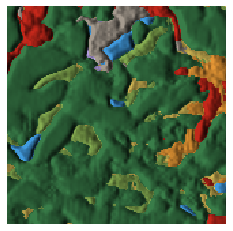

Processing complete.


In [39]:
import ee
import pandas as pd
import requests
import rasterio
import matplotlib.pyplot as plt
import os

# Authenticate and initialize the Earth Engine API.
ee.Authenticate()
ee.Initialize()

# Read the metadata CSV file.
metadata = pd.read_csv('metadata.csv')

# Define the function to process a row.
def process_row(row_index):
    try:
        # Adjust row_index to match the 0-based index in the DataFrame
        row_index -= 1
        
        # Extract the row based on the given index.
        row = metadata.iloc[row_index]
        
        # Extract the bounds from the row.
        bounds = ee.Geometry.Rectangle(eval(row['bounds']))
        date = ee.Date(row['lowres_date'])
        
        print(f"Processing row {row_index + 1} with bounds: {bounds.getInfo()} and date: {date.format().getInfo()}")
        
        # Check if the cloud cover is greater than 35%
        if row['cloud_cover'] > 35:
            print(f"Skipping row {row_index + 1} due to high cloud cover: {row['cloud_cover']}%")
            return
        
        # Filter the collections by the region and date.
        col_filter = ee.Filter.bounds(bounds)
        dw_col = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(col_filter).filterDate(date, date.advance(1, 'day'))
        s2_col = ee.ImageCollection('COPERNICUS/S2').filter(col_filter).filterDate(date, date.advance(1, 'day'))
        
        if dw_col.size().getInfo() == 0 or s2_col.size().getInfo() == 0:
            print(f"No images found for row {row_index + 1} within the specified bounds and date.")
            return
        
        # Join corresponding Dynamic World and Sentinel-2 images (by system:time_start).
        dw_s2_col = ee.Join.saveFirst('s2_img').apply(
            dw_col,
            s2_col,
            ee.Filter.equals(leftField='system:time_start', rightField='system:time_start')
        )
        
        # Extract an example Dynamic World image and its source Sentinel-2 image.
        dw_image = ee.Image(dw_s2_col.first())
        s2_image = ee.Image(dw_image.get('s2_img'))
        
        # Check if images are valid
        if not dw_image:
            print(f"Error: Unable to get Dynamic World image for row {row_index + 1}")
            return
        if not s2_image:
            print(f"Error: Unable to get Sentinel-2 image for row {row_index + 1}")
            return
        
        # Debug: Print available bands
        print("Dynamic World Image Bands:", dw_image.bandNames().getInfo() if dw_image else "No Dynamic World Image")
        print("Sentinel-2 Image Bands:", s2_image.bandNames().getInfo() if s2_image else "No Sentinel-2 Image")
        
        # Define visualization parameters
        vis_params = {
            'bands': ['label'],
            'min': 0,
            'max': 8,
            'palette': [
                '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', 
                '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1'
            ]
        }
        
        # Visualize the image
        classification = dw_image.select('label')
        dw_rgb = classification.visualize(**vis_params).divide(255)
        
        # Create an RGB image with probability.
        top1_prob = dw_image.select([
            'water', 'trees', 'grass', 'flooded_vegetation', 'crops', 
            'shrub_and_scrub', 'built', 'bare', 'snow_and_ice'
        ]).reduce(ee.Reducer.max())
        
        top1_prob_hillshade = ee.Terrain.hillshade(top1_prob.multiply(100)).divide(255)
        dw_rgb_hillshade = dw_rgb.multiply(top1_prob_hillshade)
        
        # Ensure images have the same projection by selecting a specific band from Sentinel-2
        s2_band = s2_image.select('B2')  # Select band 2 as an example
        dw_rgb_hillshade = dw_rgb_hillshade.reproject(crs=s2_band.projection())

        # Get the download URL for the image in GeoTIFF format.
        url = dw_rgb_hillshade.getDownloadURL({
            'scale': 10,
            'region': bounds,
            'format': 'GeoTIFF'
        })
        
        print(f"Download URL: {url}")
        
        # Download the image and save it to the local file system.
        response = requests.get(url, stream=True)
        tiff_output_path = f"./{row['n']}_dynamic_world_image.tif"
        if response.status_code == 200:
            with open(tiff_output_path, 'wb') as handler:
                for chunk in response.iter_content(1024):
                    handler.write(chunk)
            print(f"Downloaded image for {row['n']} to {tiff_output_path}")
            
            # Check file size
            file_size = os.path.getsize(tiff_output_path)
            print(f"File size: {file_size} bytes")
            
            # Display the TIFF file using rasterio
            with rasterio.open(tiff_output_path) as src:
                img = src.read()
                plt.imshow(img.transpose(1, 2, 0))  # Adjust dimensions for plotting
                plt.axis('off')
                plt.show()
        else:
            print(f"Failed to download image, status code: {response.status_code}")
        
    except Exception as e:
        print(f"Error processing {row['n']}: {e}")

# Specify the row index you want to process (adjusted to match 1-based indexing).
row_index = 9889

# Process the specified row.
process_row(row_index)

print("Processing complete.")


In [ ]:
# import ee
import pandas as pd
import requests
import os
import time

# Authenticate and initialize the Earth Engine API.
ee.Authenticate()
ee.Initialize()

# Read the metadata CSV file.
metadata = pd.read_csv('metadata.csv')

# Define the function to process a row.
def process_row(row_index):
    try:
        # Adjust row_index to match the 0-based index in the DataFrame
        row_index -= 1
        
        # Extract the row based on the given index.
        row = metadata.iloc[row_index]
        
        # Extract the bounds from the row.
        bounds = ee.Geometry.Rectangle(eval(row['bounds']))
        date = ee.Date(row['lowres_date'])
        
        # Check if the cloud cover is greater than 35%
        if row['cloud_cover'] > 35:
            return
        
        # Filter the collections by the region and date.
        col_filter = ee.Filter.bounds(bounds)
        dw_col = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(col_filter).filterDate(date, date.advance(1, 'day'))
        s2_col = ee.ImageCollection('COPERNICUS/S2').filter(col_filter).filterDate(date, date.advance(1, 'day'))
        
        if dw_col.size().getInfo() == 0 or s2_col.size().getInfo() == 0:
            return
        
        # Join corresponding Dynamic World and Sentinel-2 images (by system:time_start).
        dw_s2_col = ee.Join.saveFirst('s2_img').apply(
            dw_col,
            s2_col,
            ee.Filter.equals(leftField='system:time_start', rightField='system:time_start')
        )
        
        # Extract an example Dynamic World image and its source Sentinel-2 image.
        dw_image = ee.Image(dw_s2_col.first())
        s2_image = ee.Image(dw_image.get('s2_img'))
        
        # Check if images are valid
        if not dw_image or not s2_image:
            return
        
        # Define visualization parameters
        vis_params = {
            'bands': ['label'],
            'min': 0,
            'max': 8,
            'palette': [
                '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', 
                '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1'
            ]
        }
        
        # Visualize the image
        classification = dw_image.select('label')
        dw_rgb = classification.visualize(**vis_params).divide(255)
        
        # Create an RGB image with probability.
        top1_prob = dw_image.select([
            'water', 'trees', 'grass', 'flooded_vegetation', 'crops', 
            'shrub_and_scrub', 'built', 'bare', 'snow_and_ice'
        ]).reduce(ee.Reducer.max())
        
        top1_prob_hillshade = ee.Terrain.hillshade(top1_prob.multiply(100)).divide(255)
        dw_rgb_hillshade = dw_rgb.multiply(top1_prob_hillshade)
        
        # Ensure images have the same projection by selecting a specific band from Sentinel-2
        s2_band = s2_image.select('B2')  # Select band 2 as an example
        dw_rgb_hillshade = dw_rgb_hillshade.reproject(crs=s2_band.projection())
        
        # Get the download URL for the image.
        url = dw_rgb_hillshade.getDownloadURL({
            'scale': 10,
            'region': bounds,
            'format': 'GeoTIFF'
        })
        
        # Download the image and save it to the local file system.
        response = requests.get(url, stream=True)
        tiff_output_path = os.path.join("land_cover", f"dynamic_world_image_{row_index + 1}.tif")
        if response.status_code == 200:
            with open(tiff_output_path, 'wb') as handler:
                for chunk in response.iter_content(1024):
                    handler.write(chunk)
            # Print a message for every 1000 downloaded images
            if (row_index + 1) % 1000 == 0:
                print(f"Downloaded {row_index + 1} images.")
        else:
            print(f"Failed to download image for row {row_index + 1}, status code: {response.status_code}")
        
    except Exception as e:
        print(f"Error processing row {row_index + 1}: {e}")

# Create the land_cover directory if it doesn't exist
if not os.path.exists('land_cover'):
    os.makedirs('land_cover')

# Process all rows in the metadata
for i in range(1, len(metadata) + 1):
    process_row(i)

print("Processing complete.")


In [ ]:
import ee
import pandas as pd
import requests
import os
import time

# Authenticate and initialize the Earth Engine API.
ee.Authenticate()
ee.Initialize()

# Read the metadata CSV file.
metadata = pd.read_csv('metadata.csv')

# Define the function to process a row.
def process_row(row_index, retries=3):
    try:
        # Adjust row_index to match the 0-based index in the DataFrame
        row_index -= 1
        
        # Extract the row based on the given index.
        row = metadata.iloc[row_index]
        
        # Extract the bounds from the row.
        bounds = ee.Geometry.Rectangle(eval(row['bounds']))
        date = ee.Date(row['lowres_date'])
        
        # Check if the cloud cover is greater than 35%
        if row['cloud_cover'] > 35:
            return
        
        # Filter the collections by the region and date.
        col_filter = ee.Filter.bounds(bounds)
        dw_col = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(col_filter).filterDate(date, date.advance(1, 'day'))
        s2_col = ee.ImageCollection('COPERNICUS/S2').filter(col_filter).filterDate(date, date.advance(1, 'day'))
        
        if dw_col.size().getInfo() == 0 or s2_col.size().getInfo() == 0:
            return
        
        # Join corresponding Dynamic World and Sentinel-2 images (by system:time_start).
        dw_s2_col = ee.Join.saveFirst('s2_img').apply(
            dw_col,
            s2_col,
            ee.Filter.equals(leftField='system:time_start', rightField='system:time_start')
        )
        
        # Extract an example Dynamic World image and its source Sentinel-2 image.
        dw_image = ee.Image(dw_s2_col.first())
        s2_image = ee.Image(dw_image.get('s2_img'))
        
        # Check if images are valid
        if not dw_image or not s2_image:
            return
        
        # Define visualization parameters
        vis_params = {
            'bands': ['label'],
            'min': 0,
            'max': 8,
            'palette': [
                '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', 
                '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1'
            ]
        }
        
        # Visualize the image
        classification = dw_image.select('label')
        dw_rgb = classification.visualize(**vis_params).divide(255)
        
        # Create an RGB image with probability.
        top1_prob = dw_image.select([
            'water', 'trees', 'grass', 'flooded_vegetation', 'crops', 
            'shrub_and_scrub', 'built', 'bare', 'snow_and_ice'
        ]).reduce(ee.Reducer.max())
        
        top1_prob_hillshade = ee.Terrain.hillshade(top1_prob.multiply(100)).divide(255)
        dw_rgb_hillshade = dw_rgb.multiply(top1_prob_hillshade)
        
        # Ensure images have the same projection by selecting a specific band from Sentinel-2
        s2_band = s2_image.select('B2')  # Select band 2 as an example
        dw_rgb_hillshade = dw_rgb_hillshade.reproject(crs=s2_band.projection())
        
        # Get the download URL for the image.
        url = dw_rgb_hillshade.getDownloadURL({
            'scale': 10,
            'region': bounds,
            'format': 'GeoTIFF'
        })
        
        # Download the image and save it to the local file system.
        for attempt in range(retries):
            try:
                response = requests.get(url, stream=True)
                tiff_output_path = os.path.join("land_cover", f"dynamic_world_image_{row_index + 1}.tif")
                if response.status_code == 200:
                    with open(tiff_output_path, 'wb') as handler:
                        for chunk in response.iter_content(1024):
                            handler.write(chunk)
                    # Print a message for every 1000 downloaded images
                    if (row_index + 1) % 1000 == 0:
                        print(f"Downloaded {row_index + 1} images.")
                    break
                else:
                    print(f"Failed to download image for row {row_index + 1}, status code: {response.status_code}")
            except (ConnectionError, ProxyError) as e:
                print(f"Error processing row {row_index + 1}: {e}. Retrying {attempt + 1}/{retries}...")
                time.sleep(5)  # Wait before retrying
                if attempt == retries - 1:
                    print(f"Failed to download image for row {row_index + 1} after {retries} attempts.")
        
    except Exception as e:
        print(f"Error processing row {row_index + 1}: {e}")

# Create the land_cover directory if it doesn't exist
if not os.path.exists('land_cover'):
    os.makedirs('land_cover')

# Set the starting index
start_index = 24428

# Process rows from the starting index
for i in range(start_index, len(metadata) + 1):
    process_row(i)

print("Processing complete.")


/home/zhou.hanyi/.local/lib/python3.7/site-packages/ee/deprecation.py:204: DeprecationWarning: 

Attention required for COPERNICUS/S2! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

  warnings.warn(warning, category=DeprecationWarning)


Downloaded 25000 images.
Error processing row 25150: Element.get: Parameter 'object' is required.
Error processing row 25767: Image.select: Parameter 'input' is required.
Downloaded 26000 images.
Error processing row 26305: Element.get: Parameter 'object' is required.
Error processing row 26591: Element.get: Parameter 'object' is required.
Error processing row 26913: Image.select: Parameter 'input' is required.
Downloaded 27000 images.
Error processing row 27721: Element.get: Parameter 'object' is required.
Downloaded 28000 images.


In [ ]:
import ee
import pandas as pd
import requests
import os
import time

# Authenticate and initialize the Earth Engine API.
ee.Authenticate()
ee.Initialize()

# Read the metadata CSV file.
metadata = pd.read_csv('metadata.csv')

# Define the function to process a row.
def process_row(row_index, retries=3):
    try:
        # Adjust row_index to match the 0-based index in the DataFrame
        row_index -= 1
        
        # Extract the row based on the given index.
        row = metadata.iloc[row_index]
        
        # Extract the bounds from the row.
        bounds = ee.Geometry.Rectangle(eval(row['bounds']))
        date = ee.Date(row['lowres_date'])
        
        # Check if the cloud cover is greater than 35%
        if row['cloud_cover'] > 35:
            return
        
        # Filter the collections by the region and date.
        col_filter = ee.Filter.bounds(bounds)
        dw_col = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(col_filter).filterDate(date, date.advance(1, 'day'))
        s2_col = ee.ImageCollection('COPERNICUS/S2').filter(col_filter).filterDate(date, date.advance(1, 'day'))
        
        if dw_col.size().getInfo() == 0 or s2_col.size().getInfo() == 0:
            return
        
        # Join corresponding Dynamic World and Sentinel-2 images (by system:time_start).
        dw_s2_col = ee.Join.saveFirst('s2_img').apply(
            dw_col,
            s2_col,
            ee.Filter.equals(leftField='system:time_start', rightField='system:time_start')
        )
        
        # Extract an example Dynamic World image and its source Sentinel-2 image.
        dw_image = ee.Image(dw_s2_col.first())
        s2_image = ee.Image(dw_image.get('s2_img'))
        
        # Check if images are valid
        if not dw_image or not s2_image:
            return
        
        # Define visualization parameters
        vis_params = {
            'bands': ['label'],
            'min': 0,
            'max': 8,
            'palette': [
                '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', 
                '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1'
            ]
        }
        
        # Visualize the image
        classification = dw_image.select('label')
        dw_rgb = classification.visualize(**vis_params).divide(255)
        
        # Create an RGB image with probability.
        top1_prob = dw_image.select([
            'water', 'trees', 'grass', 'flooded_vegetation', 'crops', 
            'shrub_and_scrub', 'built', 'bare', 'snow_and_ice'
        ]).reduce(ee.Reducer.max())
        
        top1_prob_hillshade = ee.Terrain.hillshade(top1_prob.multiply(100)).divide(255)
        dw_rgb_hillshade = dw_rgb.multiply(top1_prob_hillshade)
        
        # Ensure images have the same projection by selecting a specific band from Sentinel-2
        s2_band = s2_image.select('B2')  # Select band 2 as an example
        dw_rgb_hillshade = dw_rgb_hillshade.reproject(crs=s2_band.projection())
        
        # Get the download URL for the image.
        url = dw_rgb_hillshade.getDownloadURL({
            'scale': 10,
            'region': bounds,
            'format': 'GeoTIFF'
        })
        
        # Download the image and save it to the local file system.
        for attempt in range(retries):
            try:
                response = requests.get(url, stream=True)
                tiff_output_path = os.path.join("land_cover", f"dynamic_world_image_{row_index + 1}.tif")
                if response.status_code == 200:
                    with open(tiff_output_path, 'wb') as handler:
                        for chunk in response.iter_content(1024):
                            handler.write(chunk)
                    # Print a message for every 1000 downloaded images
                    if (row_index + 1) % 1000 == 0:
                        print(f"Downloaded {row_index + 1} images.")
                    break
                else:
                    print(f"Failed to download image for row {row_index + 1}, status code: {response.status_code}")
            except (ConnectionError, ProxyError) as e:
                print(f"Error processing row {row_index + 1}: {e}. Retrying {attempt + 1}/{retries}...")
                time.sleep(5)  # Wait before retrying
                if attempt == retries - 1:
                    print(f"Failed to download image for row {row_index + 1} after {retries} attempts.")
        
    except Exception as e:
        print(f"Error processing row {row_index + 1}: {e}")

# Create the land_cover directory if it doesn't exist
if not os.path.exists('land_cover'):
    os.makedirs('land_cover')

# Set the starting index
start_index = 34712

# Process rows from the starting index
for i in range(start_index, len(metadata) + 1):
    process_row(i)

print("Processing complete.")


/home/zhou.hanyi/.local/lib/python3.7/site-packages/ee/deprecation.py:204: DeprecationWarning: 

Attention required for COPERNICUS/S2! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

  warnings.warn(warning, category=DeprecationWarning)


Downloaded 35000 images.
Error processing row 35349: Image.select: Parameter 'input' is required.
Error processing row 35426: Element.get: Parameter 'object' is required.
Error processing row 35542: Element.get: Parameter 'object' is required.
Error processing row 35978: Image.select: Parameter 'input' is required.
Downloaded 36000 images.
Error processing row 36019: Element.get: Parameter 'object' is required.
Error processing row 36124: Element.get: Parameter 'object' is required.
Error processing row 36489: Image.select: Parameter 'input' is required.
Downloaded 37000 images.
Error processing row 37621: Image.select: Parameter 'input' is required.
Error processing row 37806: Element.get: Parameter 'object' is required.
Downloaded 38000 images.
Failed to download image for row 38116, status code: 503
Downloaded 39000 images.
Error processing row 39388: Image.select: Parameter 'input' is required.
Downloaded 40000 images.
Error processing row 40514: Image.select: Parameter 'input' is 

In [3]:
import ee
import pandas as pd
import requests
import os
import time

# Authenticate and initialize the Earth Engine API.
ee.Authenticate()
ee.Initialize()

# Read the metadata CSV file.
metadata = pd.read_csv('metadata.csv')

# Define the function to process a row.
def process_row(row_index, retries=3):
    try:
        # Adjust row_index to match the 0-based index in the DataFrame
        row_index -= 1
        
        # Extract the row based on the given index.
        row = metadata.iloc[row_index]
        
        # Extract the bounds from the row.
        bounds = ee.Geometry.Rectangle(eval(row['bounds']))
        date = ee.Date(row['lowres_date'])
        
        # Check if the cloud cover is greater than 35%
        if row['cloud_cover'] > 35:
            return
        
        # Filter the collections by the region and date.
        col_filter = ee.Filter.bounds(bounds)
        dw_col = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(col_filter).filterDate(date, date.advance(1, 'day'))
        s2_col = ee.ImageCollection('COPERNICUS/S2').filter(col_filter).filterDate(date, date.advance(1, 'day'))
        
        if dw_col.size().getInfo() == 0 or s2_col.size().getInfo() == 0:
            return
        
        # Join corresponding Dynamic World and Sentinel-2 images (by system:time_start).
        dw_s2_col = ee.Join.saveFirst('s2_img').apply(
            dw_col,
            s2_col,
            ee.Filter.equals(leftField='system:time_start', rightField='system:time_start')
        )
        
        # Extract an example Dynamic World image and its source Sentinel-2 image.
        dw_image = ee.Image(dw_s2_col.first())
        s2_image = ee.Image(dw_image.get('s2_img'))
        
        # Check if images are valid
        if not dw_image or not s2_image:
            return
        
        # Define visualization parameters
        vis_params = {
            'bands': ['label'],
            'min': 0,
            'max': 8,
            'palette': [
                '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', 
                '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1'
            ]
        }
        
        # Visualize the image
        classification = dw_image.select('label')
        dw_rgb = classification.visualize(**vis_params).divide(255)
        
        # Create an RGB image with probability.
        top1_prob = dw_image.select([
            'water', 'trees', 'grass', 'flooded_vegetation', 'crops', 
            'shrub_and_scrub', 'built', 'bare', 'snow_and_ice'
        ]).reduce(ee.Reducer.max())
        
        top1_prob_hillshade = ee.Terrain.hillshade(top1_prob.multiply(100)).divide(255)
        dw_rgb_hillshade = dw_rgb.multiply(top1_prob_hillshade)
        
        # Ensure images have the same projection by selecting a specific band from Sentinel-2
        s2_band = s2_image.select('B2')  # Select band 2 as an example
        dw_rgb_hillshade = dw_rgb_hillshade.reproject(crs=s2_band.projection())
        
        # Get the download URL for the image.
        url = dw_rgb_hillshade.getDownloadURL({
            'scale': 10,
            'region': bounds,
            'format': 'GeoTIFF'
        })
        
        # Download the image and save it to the local file system.
        for attempt in range(retries):
            try:
                response = requests.get(url, stream=True)
                tiff_output_path = os.path.join("land_cover", f"dynamic_world_image_{row_index + 1}.tif")
                if response.status_code == 200:
                    with open(tiff_output_path, 'wb') as handler:
                        for chunk in response.iter_content(1024):
                            handler.write(chunk)
                    # Print a message for every 1000 downloaded images
                    if (row_index + 1) % 1000 == 0:
                        print(f"Downloaded {row_index + 1} images.")
                    break
                else:
                    print(f"Failed to download image for row {row_index + 1}, status code: {response.status_code}")
            except (ConnectionError, ProxyError) as e:
                print(f"Error processing row {row_index + 1}: {e}. Retrying {attempt + 1}/{retries}...")
                time.sleep(5)  # Wait before retrying
                if attempt == retries - 1:
                    print(f"Failed to download image for row {row_index + 1} after {retries} attempts.")
        
    except Exception as e:
        print(f"Error processing row {row_index + 1}: {e}")

# Create the land_cover directory if it doesn't exist
if not os.path.exists('land_cover'):
    os.makedirs('land_cover')

# Set the starting index
start_index = 58021

# Process rows from the starting index
for i in range(start_index, len(metadata) + 1):
    process_row(i)

print("Processing complete.")


KeyboardInterrupt: 